In [15]:
# If necessary

!pip install lambeq
!pip install pennylane

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for pennylane from https://files.pythonhosted.org/packages/ec/12/783161913f263cc311fb686b05c0e7abb42f87b158f49664f95472aa2135/PennyLane-0.32.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 28.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 8.2 MB/s eta 0:00:00
  Obtaining dependency information for autoray>=0.3.1 from https://files.pythonhosted.org/packages/ad/93/c274651e4b9994edf77ab0af094c858c6a949c372f8d459920b1818f570e/autoray-0.6.7-py3-none-any.whl.metadata
  Obtaining dependency information for cachetools from https://files.pythonhosted.org/packages/a9/c9/c8a7710f2cedcb1db9224fdd4d8307c9e48cbddc46c18b515fefc0f1abbe/cachetools-5.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for pennylane-lightning>=0.32 from https://files.pythonhosted.org/packages/77/24/8fab61e0a7719da8df794518d9f903147a5af6ba36f6ad344a6e238a0024/PennyLane_Lightning-0.32.0-py3-none-a

In [6]:
BATCH_SIZE = 10
EPOCHS = 15
LEARNING_RATE = 0.1
SEED = 42

import torch
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [16]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../semantiq/datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('../semantiq/datasets/mc_dev_data.txt')
test_labels, test_data = read_data('../semantiq/datasets/mc_test_data.txt')


# Prepare data & optimize it by simplifying diagrams when possible

from lambeq import BobcatParser, remove_cups

reader = BobcatParser(verbose='text')

raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


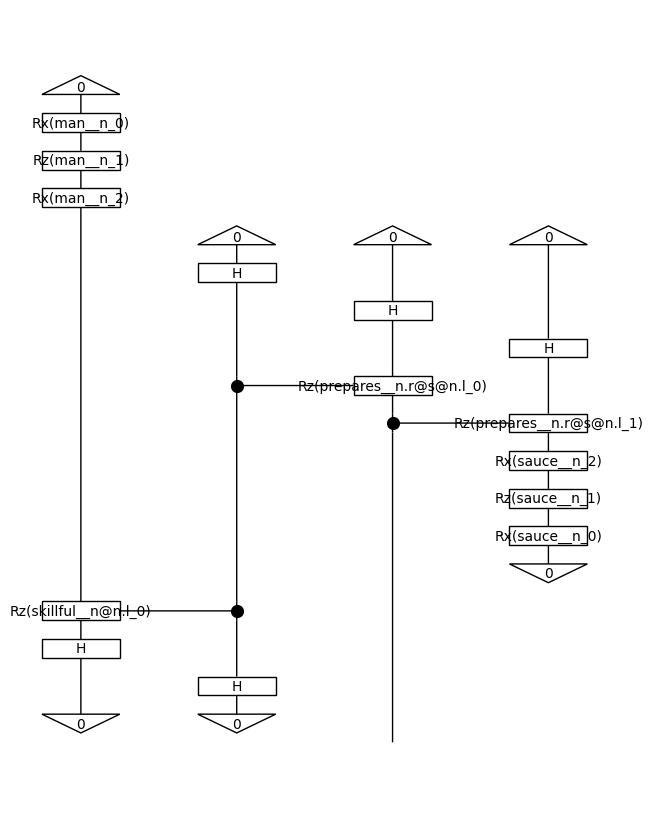

In [17]:
# Diagram to circuit conversion -- use lambeq ansatz

from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))


from lambeq import PennyLaneModel

all_circuits = train_circuits + dev_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
model = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
model.initialise_weights()

In [18]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels)

def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)


from lambeq import PytorchTrainer

trainer = PytorchTrainer(
    model=model,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)



Epoch 1:   train/loss: 0.2608   valid/loss: 0.3280   train/acc: 0.5571   valid/acc: 0.4333
Epoch 2:   train/loss: 0.1752   valid/loss: 0.1515   train/acc: 0.7000   valid/acc: 0.8333
Epoch 3:   train/loss: 0.0917   valid/loss: 0.0909   train/acc: 0.8714   valid/acc: 0.9333
Epoch 4:   train/loss: 0.0547   valid/loss: 0.0691   train/acc: 0.9429   valid/acc: 0.9000
Epoch 5:   train/loss: 0.0333   valid/loss: 0.0762   train/acc: 0.9286   valid/acc: 0.9333
Epoch 6:   train/loss: 0.0251   valid/loss: 0.0590   train/acc: 0.9429   valid/acc: 0.9000
Epoch 7:   train/loss: 0.0432   valid/loss: 0.1318   train/acc: 0.9286   valid/acc: 0.8000
Epoch 8:   train/loss: 0.0419   valid/loss: 0.0764   train/acc: 0.9571   valid/acc: 0.9000
Epoch 9:   train/loss: 0.0482   valid/loss: 0.0833   train/acc: 0.9714   valid/acc: 0.8667
Epoch 10:  train/loss: 0.0394   valid/loss: 0.0520   train/acc: 0.9714   valid/acc: 0.9000
Epoch 11:  train/loss: 0.0154   valid/loss: 0.0342   train/acc: 0.9857   valid/acc: 1.0000

AttributeError: 'PytorchTrainer' object has no attribute 'train_eval_results'

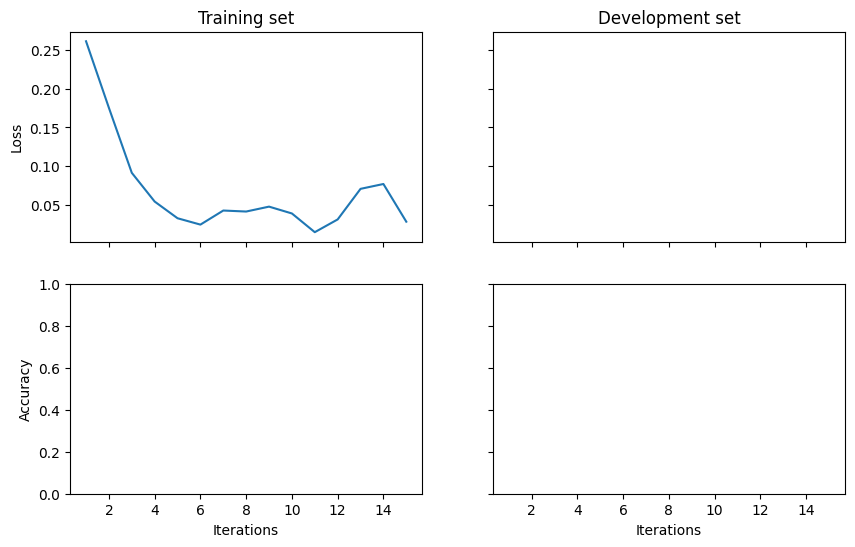

In [19]:
# train & visualize
trainer.fit(train_dataset, val_dataset)
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

